In [61]:
import pandas as pd
import numpy as np

In [62]:
ds_train = pd.read_csv('ds/train.csv')
ds_songs = pd.read_csv('ds/songs.csv')
ds_songs_extra_info = pd.read_csv('ds/song_extra_info.csv')
ds_members = pd.read_csv('ds/members.csv')

### Беру только 15% от датасета, потому что построение предложений идут очень долго =(

In [63]:
ds_train = ds_train.sample(frac=0.15)

In [64]:
X_train = ds_train.sample(frac=0.8)
X_test = ds_train.drop(X_train.index)

### В качестве предложений(sentence) для каждого юзера буду рассматривать список песен, которые он лайкнул. Где айдишки песен - слова для word2vec

In [65]:
X_train_pos = X_train[X_train['target'] == 1]

In [66]:
from tqdm.notebook import tqdm, trange

In [67]:
users = np.unique(X_train_pos['msno'].values)
user_pos_history = [X_train_pos[X_train_pos['msno'] == user]['song_id'].astype(str).tolist() for user in tqdm(users)]

In [69]:
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score

In [70]:
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

### Эмбеддинги для юзеров беру как средний вектор лайкнутых песен

In [93]:
def get_user_embeddings(X, y, model):
    embeddings = dict()
    count = dict()
    for (index, row), target in tqdm(zip(X_train.iterrows(), y_train)):
        if target == 1:
            user_id = row['msno']
            song_id = row['song_id']
            if song_id in songs_in_dict:
                if song_id in model.wv:
                    if user_id not in count:
                        count[user_id] = 0
                    if user_id not in embeddings:
                        embeddings[user_id] = np.zeros(100)
                    embeddings[user_id] += model.wv.get_vector(song_id, norm=True)
                    count[user_id] += 1
    for user_id in embeddings.keys():
        embeddings[user_id] /= count[user_id]
    return embeddings    

In [94]:
def get_user_song_dot(user_id, song_id, user_embeddings, songs_in_dict, model):
    if user_id not in user_embeddings:
        return 0
    if song_id not in songs_in_dict:
        return 0
    uv = user_embeddings[user_id]
    sv = model.wv.get_vector(song_id)
    
    u_n = np.linalg.norm(uv)
    s_n = np.linalg.norm(sv)
    return np.dot(uv / u_n, sv / s_n)

In [98]:
def calc_auc_roc(model, user_embeddings):
    X_test_c = X_test.copy()
    target_res = []
    songs_in_dict = list(model.wv.key_to_index.keys())
    for index, row in tqdm(X_test_c.iterrows()):
        user_id = row['msno']
        song_id = row['song_id']
        target_res.append(get_user_song_dot(user_id, song_id, user_embeddings, songs_in_dict, model))
    return roc_auc_score(y_test, target_res)

In [110]:
def get_best_params_for_w2v():
    windows = [10, 15, 17, 20]
    negatives = [3, 8, 15]
    alphas = [0.03, 0.07, 0.15]
    epochs = [10, 30, 50]
    for window in windows:
        model = Word2Vec(window=window, sg=1, hs=0, negative=8, alpha=0.07)
        model.build_vocab(user_pos_history)
        model.train(user_pos_history, total_examples=len(user_pos_history), epochs=30)
        user_embeddings = get_user_embeddings(X_train, y_train, model)
        auc = calc_auc_roc(model, user_embeddings)
        print("window=",window," ,auc=",auc) 

In [112]:
get_best_params_for_w2v()


window= 10  ,auc= 0.629426504404691



window= 15  ,auc= 0.6277959982013428



window= 17  ,auc= 0.6273635300709198



window= 20  ,auc= 0.626014403000967


### Повызывал прошлую функцию несколько раз, перебирая разные параметры. Нашел лучшую комбинацию

window= 10  ,auc= 0.6297144126627747

neg= 8  ,auc= 0.6294574276510667

alpha= 0.07  ,auc= 0.6297221665853026

epo= 30  ,auc= 0.6294950227709386

In [113]:
lengths = [len(arr) for arr in user_pos_history]
np.mean(lengths)

19.126925552456555

In [114]:
w2v = Word2Vec(window=10, sg=1, hs=0, negative=8, alpha=0.07)

In [115]:
w2v.build_vocab(user_pos_history)

In [116]:
w2v.train(user_pos_history, total_examples=len(user_pos_history), epochs=30)

(10674119, 13372590)

In [117]:
ds_songs = ds_songs.merge(ds_songs_extra_info,on='song_id',how='left')

In [118]:
ds_songs.shape

(2296320, 11)

In [119]:
print(w2v)

Word2Vec(vocab=12262, vector_size=100, alpha=0.07)


In [127]:
def get_similars(name):
    sims = w2v.wv.most_similar_cosmul(name, topn=1000)
    data = []
    for song, similarity in sims:
        d = ds_songs[ds_songs['song_id'] == song].to_dict('records')[0]
        d['similarity'] = similarity
        data.append(d)
    return pd.DataFrame(data)

In [131]:
# name = '0ee/D6HjX0jSytUn3v58C0x6zEzN4bcPq3WlqvrG/Xo=' # heathens, Twenty one pilots
name = 'e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=' # Shape of you
print(name)
dff = get_similars(name)

e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=


In [132]:
dff[dff['language']==52.0].head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name_x,isrc_x,name_y,isrc_y,similarity
3,IKMFuL0f5Y8c63Hg9BXkeNJjE0z8yf3gMt/tOxF4QNE=,244976,1609,The Chainsmokers,Andrew Taggart| Shaun Frank| Frederic Kennett|...,Andrew Taggart| Shaun Frank| Frederic Kennett|...,52.0,Closer,USQX91601347,Closer,USQX91601347,0.794069
5,n+FLlTL+LrNTa6xpoGkESEzlUMb/hPEM1nLq2U6fEp0=,261172,465,Ed Sheeran,Ed Sheeran| Benjamin Levin,NaN,52.0,Castle on the Hill,GBAHS1600462,Castle on the Hill,GBAHS1600462,0.791956
6,MtFK4NN8Kv1k/xPA3wb8SQaP/jWee52FAaC1s9NFsU4=,222197,1609,Calvin Harris,Calvin Harris| Taylor Swift,Calvin Harris| Taylor Swift,52.0,This Is What You Came For,GBARL1600460,This Is What You Came For,GBARL1600460,0.790852
7,0b8M2FLEH176y/ng1rK9ftUYDYnA+1NdoCOUeuyBMtU=,221544,1609,The Chainsmokers,Andrew Taggart| Kris Eriksson| Fredrik Häggstam,Andrew Taggart| Kris Eriksson| Fredrik Häggstam,52.0,Paris,USQX91603031,Paris,USQX91603031,0.785878
8,XA08z3r0wdQvY3CE0lFDTd/MuAgD7b0XKZnCvo+ylKE=,245109,921,ZAYN| Taylor Swift,Taylor Swift| Jack Antonoff| Sam Dew,NaN,52.0,I Don’t Wanna Live Forever (Fifty Shades Darker),USQ4E1602586,I Don’t Wanna Live Forever (Fifty Shades Darker),USQ4E1602586,0.783988
10,zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=,189361,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,52.0,Sing Me to Sleep,NOG841611010,Sing Me to Sleep,NOG841611010,0.782662
12,i356q8t0P9emMJq8PsFkY6CGoi34mP3cgXuDpfEDyhY=,195735,1616,Martin Garrix| Bebe Rexha,Martijn Garritsen| Matthew Radosevich| Ruth An...,Martijn Garritsen| Matthew Radosevich| Ruth An...,52.0,In the Name of Love,NLM5S1600003,In the Name of Love,NLM5S1600003,0.778409
13,J4qKkLIoW7aYACuTupHLAPZYmRp08en1AEux+GSUzdw=,212750,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,52.0,Faded,NOG841549010,Faded,NOG841549010,0.775520
15,3VkD5ekIf5duJm1hmYTZlXjyl0zqV8wCzuAh3uocfCg=,217730,465,CHARLIE PUTH,NaN,NaN,52.0,We Don't Talk Anymore,USAT21502909,We Don't Talk Anymore,USAT21502909,0.774718
18,+LztcJcPEEwsikk6+K5udm06XJQMzR4+lzavKLUyE0k=,208492,1609,The Chainsmokers,Andrew Taggart| Emily Warren| Scott Harris,Andrew Taggart| Emily Warren| Scott Harris,52.0,Don't Let Me Down,USQX91600011,Don't Let Me Down,USQX91600011,0.772148


In [122]:
song_data_name_author = []
songs_in_dict = list(w2v.wv.key_to_index.keys())
# for song_id in tqdm(w2v.wv.key_to_index.keys()):
#     print(song_id, ds_songs[ds_songs['song_id'] == song_id]['name'], ds_songs[ds_songs['song_id'] == song_id]['artist_name'])
#     song_data_name_author.append((song_id, ds_songs[ds_songs['song_id'] == song_id]['name'], ds_songs[ds_songs['song_id'] == song_id]['artist_name']))

In [123]:
# w2v.wv.get_vector("e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=",norm=True)

In [124]:
user_embeddings = get_user_embeddings(X_train, y_train, w2v)

### Результат хуже, чем у бустинга, вероятно мало данных, и много пропущенных песен

In [125]:
calc_auc_roc(w2v, user_embeddings)

0.6293630788553305

# Добавим эти данные к GBDT 

In [28]:
# ds_train = pd.read_csv('ds/train.csv')
# ds_songs = pd.read_csv('ds/songs.csv')
# ds_songs_extra_info = pd.read_csv('ds/song_extra_info.csv')
# ds_members = pd.read_csv('ds/members.csv')

## (Дальше немного пойдет копипаста 1 части)

In [133]:
genres_for_song = ds_songs['genre_ids'].apply(lambda x: [int(v) for v in str(x).split('|') if v != 'nan'])

In [134]:
genres = dict()
for genre_list in genres_for_song:
    for g in genre_list:
        if g not in genres:
            genres[g] = 0
        genres[g] += 1

In [135]:
sorted_genres = {k: v for k, v in reversed(sorted(genres.items(), key=lambda item: item[1]))}
sorted_genres['0'] = -1

In [136]:
def get_most_popular(g_list):
    res = '0'
    for g in g_list:
        if sorted_genres[res] < sorted_genres[g]:
            res = g
    return res

In [137]:
most_pop = []
for genre_list in genres_for_song:
    most_pop.append(get_most_popular(genre_list))

In [138]:
ds_songs['genre_ids'] = most_pop

In [139]:
def leave_first(column):
    items = ds_songs[column].apply(lambda x: [v for v in str(x).split('|')])
    res = [v[0] for v in items]
    ds_songs[column] = res

In [140]:
leave_first('artist_name')
leave_first('composer')
leave_first('lyricist')

In [141]:
ds_train = ds_train.merge(ds_members,on='msno',how='left')
ds_train = ds_train.merge(ds_songs,on='song_id',how='left')
ds_train = ds_train.fillna(0)

In [142]:
ds_train.drop(columns=['registration_init_time','expiration_date','song_length'], inplace=True)

In [143]:
ds_train['language'] = ds_train['language'].astype(int).astype('category')
ds_train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,genre_ids,artist_name,composer,lyricist,language,name_x,isrc_x,name_y,isrc_y
0,e9/q+cgrD4qiElNXFx/gXrJythEnoVqXG+TiySLTwjs=,itS9I3/F6ocB8d57PCV7ye2H0jFbfebHYotvrUDOUHk=,my library,Local playlist more,local-playlist,1,13,7,male,3,465,黃鴻升 (Alien Huang),黃鴻升/衛斯理,黃鴻升/衛斯理,3,忘了我,TWA451507061,忘了我,TWA451507061
1,gjFD3HBX+vzTnUfX8N39j6LkpiQIaEHuKKzUlkFdJ7s=,izWkEacMHX6lc+hEC3QnWwWd2LXiHZ9tacUNpfUz+aw=,discover,Online playlist more,song-based-playlist,0,22,29,0,9,465,彭佳慧 (Julia Peng),Xiao Huang Qi,Chen Hong Yu,3,大齡女子 (Darling),TWW851500003,大齡女子 (Darling),TWW851500003
2,LPuZh7eV6wKEJ4OFxV3qQUOZt6n+Ay5xQ9oznhDc6FQ=,c2gmsQ0uEDZQM3lr54HdW+iPmr+a+JWJQ55YZ9oQP60=,search,Search,song,1,11,58,male,9,465,玖壹壹,陳皓宇,廖建至 洪瑜鴻 陳皓宇,3,來去趴踢,TWA451500405,來去趴踢,TWA451500405


In [146]:
def get_dots(row):
    user_id = row['msno']
    song_id = row['song_id']
    return get_user_song_dot(user_id, song_id, user_embeddings, songs_in_dict, w2v)

In [147]:
ds_train['dot'] = ds_train.apply(lambda row: get_dots(row), axis=1)

In [148]:
X_train=ds_train.sample(frac=0.8)
X_test=ds_train.drop(X_train.index)

In [149]:
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

In [150]:
ds_train.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,genre_ids,artist_name,composer,lyricist,language,name_x,isrc_x,name_y,isrc_y,dot
0,e9/q+cgrD4qiElNXFx/gXrJythEnoVqXG+TiySLTwjs=,itS9I3/F6ocB8d57PCV7ye2H0jFbfebHYotvrUDOUHk=,my library,Local playlist more,local-playlist,1,13,7,male,3,465,黃鴻升 (Alien Huang),黃鴻升/衛斯理,黃鴻升/衛斯理,3,忘了我,TWA451507061,忘了我,TWA451507061,0.406199
1,gjFD3HBX+vzTnUfX8N39j6LkpiQIaEHuKKzUlkFdJ7s=,izWkEacMHX6lc+hEC3QnWwWd2LXiHZ9tacUNpfUz+aw=,discover,Online playlist more,song-based-playlist,0,22,29,0,9,465,彭佳慧 (Julia Peng),Xiao Huang Qi,Chen Hong Yu,3,大齡女子 (Darling),TWW851500003,大齡女子 (Darling),TWW851500003,0.555125


In [152]:
X_train.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,genre_ids,artist_name,composer,lyricist,language,name_x,isrc_x,name_y,isrc_y,dot
497116,BJ4IoqvSC7vlIZsvJE7erLTGeao40C4VSG3tBO2b9DQ=,WrVxXdOuRrPQ7gqqSYG1wEFkA6Uz/cP+bf+YmZRe4S4=,my library,Local playlist more,local-library,4,31,female,9,465,AOA,nan,nan,31,짧은치마,TWA531401119,짧은치마,TWA531401119,0.487422
286948,cfY04m6apWNCKMg8+znTEgI4NUigK33cXe2Xgth6IWI=,k8s6aRatZAv/w4exkA4Oa8r75gBrxG0z3CHdb9Lrexc=,discover,Online playlist more,song-based-playlist,1,0,0,7,465,Eric 周興哲,Eric 周興哲,吳易緯,3,以後別做朋友,TWA471410001,以後別做朋友,TWA471410001,0.311567


In [153]:
X_train = X_train.drop(columns=['source_system_tab','source_screen_name','source_type','city','registered_via','isrc_x','isrc_y','name_x','name_y'])
X_test = X_test.drop(columns=['source_system_tab','source_screen_name','source_type','city','registered_via','isrc_x','isrc_y','name_x','name_y'])

In [154]:
X_train.head(2)

,msno,song_id,bd,gender,genre_ids,artist_name,composer,lyricist,language,dot
497116,BJ4IoqvSC7vlIZsvJE7erLTGeao40C4VSG3tBO2b9DQ=,WrVxXdOuRrPQ7gqqSYG1wEFkA6Uz/cP+bf+YmZRe4S4=,31,female,465,AOA,nan,nan,31,0.487422
286948,cfY04m6apWNCKMg8+znTEgI4NUigK33cXe2Xgth6IWI=,k8s6aRatZAv/w4exkA4Oa8r75gBrxG0z3CHdb9Lrexc=,0,0,465,Eric 周興哲,Eric 周興哲,吳易緯,3,0.311567


In [155]:
from catboost import CatBoostClassifier

In [156]:
cat_features = [0, 1, 3, 4, 5, 6, 7, 8]

In [157]:
clf = CatBoostClassifier(iterations=200, verbose=20, cat_features=cat_features)

In [158]:
clf.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.5688280	total: 1.24s	remaining: 4m 6s
20:	learn: 0.4307859	total: 23.3s	remaining: 3m 18s
40:	learn: 0.4232514	total: 45.6s	remaining: 2m 56s
60:	learn: 0.4200058	total: 1m 5s	remaining: 2m 28s
80:	learn: 0.4178979	total: 1m 23s	remaining: 2m 3s
100:	learn: 0.4161719	total: 1m 43s	remaining: 1m 41s
120:	learn: 0.4153608	total: 2m 2s	remaining: 1m 19s
140:	learn: 0.4141555	total: 2m 20s	remaining: 58.7s
160:	learn: 0.4134442	total: 2m 39s	remaining: 38.5s
180:	learn: 0.4128367	total: 2m 55s	remaining: 18.5s
199:	learn: 0.4121316	total: 3m 14s	remaining: 0us


In [159]:
prediction = clf.predict(X_test)

In [160]:
print(roc_auc_score(y_test, prediction))

0.8176019423505826


In [161]:
import shap  # package used to calculate Shap values

In [162]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

In [163]:
# Calculate Shap values
shap_values = explainer.shap_values(X_test)

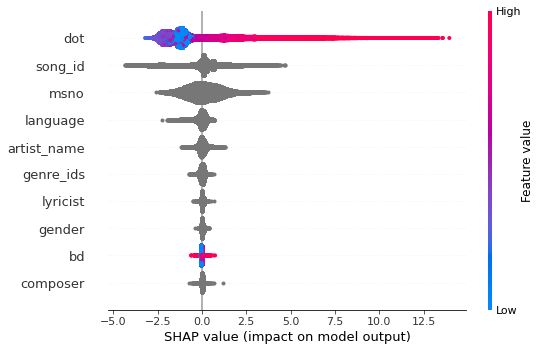

In [164]:
shap.summary_plot(shap_values, X_test)

### dot - самый важный признак

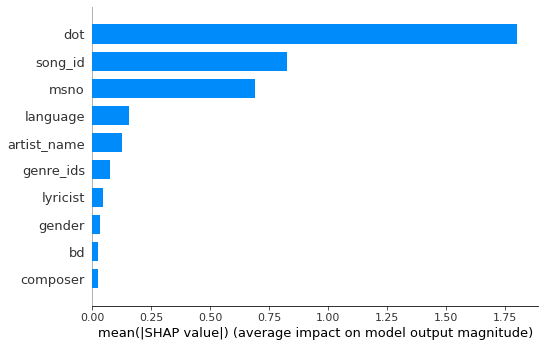

In [165]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [166]:
X_train.head(10)

,msno,song_id,bd,gender,genre_ids,artist_name,composer,lyricist,language,dot
497116,BJ4IoqvSC7vlIZsvJE7erLTGeao40C4VSG3tBO2b9DQ=,WrVxXdOuRrPQ7gqqSYG1wEFkA6Uz/cP+bf+YmZRe4S4=,31,female,465,AOA,nan,nan,31,0.487422
286948,cfY04m6apWNCKMg8+znTEgI4NUigK33cXe2Xgth6IWI=,k8s6aRatZAv/w4exkA4Oa8r75gBrxG0z3CHdb9Lrexc=,0,0,465,Eric 周興哲,Eric 周興哲,吳易緯,3,0.311567
697267,tLuCHBbzcK9gsolqZdEQBT+6SRRk3KONKlPuLqa8S+w=,ZR8NR3x8/NWKIL6rZ4z/55yHN0x2CkfMCwDZadRuDVk=,20,female,465,郭靜 (Claire Kuo),黎偌天,廖瑩如,3,0.403047
273823,q+58LOnd51IOM4YLXYsenOTH6+33/Mtoq0fpJ1iuvKY=,H9SPhwq9W0h/3XECeWOjmDRiVN7V5bxTLFlOqWDcqrI=,29,male,458,葛仲珊 (MISS KO),Miss Ko,nan,3,0.483311
952155,bRhIt1gWorfREUa+9KJxO9Sg0TUQ5q/XJ2NHIA969Q0=,TIwOs7iFTKo3Cy2yiNReYYcZc1JyAx+0k08+z97k1dA=,0,0,465,汪蘇瀧 (Silence Wang),汪蘇瀧,汪蘇瀧,3,0.562879
810539,5LbuSqfyljnN//xFe4AFcwxrZVIc+bMnOje9GfeuIps=,6G4q15dGxC+rscOS/h3dc3QuVtIcKmmwvtU4eIEvTZk=,0,0,921,Various Artists,Justin Hurwitz,nan,52,0.470250
556839,UFcltK3u/LmkJq5NM9GS/tFHLtFp9qRXO8jxore1YHE=,ZlOnHuVWBp+en8zz8founYGng6LxSu0Yra9hcV9oa9A=,23,male,465,天國的嫁衣電視原聲帶,Cui Yan,Cui Yan,3,0.198587
840393,FvJnN/5Vos3OZbhGBEwf99D9ExvJwzfstknuJG1GkOA=,5q4MUJaFkcwKdyspPSlZWmsyl5y8Wfc/ETfyc1unapQ=,43,male,465,張清芳 (Stella Chang),nan,nan,3,0.000000
1012351,C854qgTb3Zeb5mnGXwZ+vOKhkq+V2z2AlQIXNwApZHg=,2m7K4/LAhMVqqKdUE4BrkVQLK1hKwxEYUogLdxNfO7E=,27,male,465,Connie Talbot,nan,nan,52,0.272488
529410,Q0PmaEFIY4/IulAKUiT8TTMyAGSA5fI+DEOAc0earY4=,76rXwpBxGfOWBf9cW3I55rpqmKpYsSUqfM7vbBMaFzw=,0,0,444,올마이티,Oh Youngbin,Oh Youngbin,31,0.000000
